In [163]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [151]:
params={
    'n_fast_simple':2,
    'n_slow_simple':4,
    'n_fast_advanced':2,
    'n_slow_advanced':1,
    'n_partition_simple':7,
    'n_partition_advanced':4,
    'range_tasks_partition_simple':[5,8],
    'range_tasks_partition_advanced':[4,6],
    
    'load_partition_simple':0.6,
    'load_partition_advanced':0.3,
    'fast_performance':100,
    'slow_performance':50,
    'simple_operations':"f1",
    'advanced_operations':"f1;f2",
    'tasks_periods':[100, 500, 1000, 1500, 3000],
}

In [152]:
def create_system(config, system_file=None):
    df_system = pd.DataFrame(columns=['Performance','Functionality'])
    
    #добавить простые быстрые
    np_tmp = pd.DataFrame(columns=['Performance','Functionality'])
    np_tmp['Performance'] = [config['fast_performance']] * config['n_fast_simple']
    np_tmp['Functionality'] = [config['simple_operations']] * config['n_fast_simple']
    df_system = df_system.append(np_tmp, ignore_index=True)
    #добавить простые медленные
    np_tmp = pd.DataFrame(columns=['Performance','Functionality'])
    np_tmp['Performance'] = [config['slow_performance']] * config['n_slow_simple']
    np_tmp['Functionality'] = [config['simple_operations']] * config['n_slow_simple']
    df_system = df_system.append(np_tmp, ignore_index=True)
    #добавить сложные быстрые
    np_tmp = pd.DataFrame(columns=['Performance','Functionality'])
    np_tmp['Performance'] = [config['fast_performance']] * config['n_fast_advanced']
    np_tmp['Functionality'] = [config['advanced_operations']] * config['n_fast_advanced']
    df_system = df_system.append(np_tmp, ignore_index=True)
    #добавить сложные медленные
    np_tmp = pd.DataFrame(columns=['Performance','Functionality'])
    np_tmp['Performance'] = [config['slow_performance']] * config['n_slow_advanced']
    np_tmp['Functionality'] = [config['advanced_operations']] * config['n_slow_advanced']
    df_system = df_system.append(np_tmp, ignore_index=True)
    
    if system_file != None:
        df_system.to_csv(system_file, sep='\t')
         
    return df_system

In [153]:
def create_task(config, task_file=None):
    df_task = pd.DataFrame(columns=['partition', 'complexity', 'period', 'functionalities'])
    
    # сложность выполняемая всеми продвинутыми процессорами за 1 времени
    advanced_performance = config['n_fast_advanced']*config['fast_performance'] + \
                           config['n_slow_advanced']*config['slow_performance']
    # сложность выполняемая всеми  процессорами за 1 времени
    simple_performance = config['n_fast_simple']*config['fast_performance'] + \
                         config['n_slow_simple']*config['slow_performance'] + \
                         advanced_performance
    
    rows_list = []
    # добавляем обычные разделы
    for partition in range(1,config['n_partition_simple']+1):
        # определяем число задач в разделе
        n_task_partition = np.random.randint(config['range_tasks_partition_simple'][0],\
                                             config['range_tasks_partition_simple'][1]+1)
        for task in range(n_task_partition):
            #choose period 
            T = config['tasks_periods'][np.random.randint(len(config['tasks_periods']))]
            row = [partition, 0, T, config['simple_operations']]
            rows_list.append(row)
    
    df_task_tmp = pd.DataFrame(rows_list,columns=['partition', 'complexity', 'period', 'functionalities'])
    df_task_tmp['complexity'] = np.round(config['load_partition_simple']/df_task_tmp.shape[0] * \
                                         df_task_tmp['period'] * simple_performance)
    df_task = df_task.append(df_task_tmp)
    
    rows_list = []
    # добавляем продвинутые разделы
    for partition in range(1,config['n_partition_advanced']+1):
        # определяем число задач в разделе
        n_task_partition = np.random.randint(config['range_tasks_partition_advanced'][0],\
                                             config['range_tasks_partition_advanced'][1]+1)
        for task in range(n_task_partition):
            #choose period 
            T = config['tasks_periods'][np.random.randint(len(config['tasks_periods']))]
            row = [partition + config['n_partition_simple'], 0, T, config['advanced_operations']]
            rows_list.append(row)
    
    df_task_tmp = pd.DataFrame(rows_list,columns=['partition', 'complexity','period', 'functionalities'])
    df_task_tmp['complexity'] = np.round(config['load_partition_simple']/df_task_tmp.shape[0] * \
                                         df_task_tmp['period'] * advanced_performance)
    df_task = df_task.append(df_task_tmp,  ignore_index=True)
    
    df_task = df_task.astype({'partition':float, 'complexity':float, 'period':float})
    
    if task_file != None:
        df_task.to_csv(task_file, sep='\t')

    return df_task

In [154]:
def compute_load(config, df_task):
    # сложность выполняемая всеми продвинутыми процессорами за 1 времени
    advanced_performance = config['n_fast_advanced']*config['fast_performance'] + \
                           config['n_slow_advanced']*config['slow_performance']
    # сложность выполняемая всеми  процессорами за 1 времени
    simple_performance = config['n_fast_simple']*config['fast_performance'] + \
                         config['n_slow_simple']*config['slow_performance'] + \
                         advanced_performance
    # T = 3000 цикл планированяи
    T = 3000
    
    task_complex_list = df_task['complexity']*(T/df_task['period'])
    task_complex = task_complex_list.sum()
    
    load = task_complex/(simple_performance*T)
    return load

In [155]:
def create_configuration(params,path='TEST'):
    if not os.path.exists(path):
        os.mkdir(path)
    create_system(params, system_file=path+'/'+'system')
    df_task = create_task(params, task_file=path+'/'+'task')
    config = params.copy()
    config['real_load'] = compute_load(params,df_task)
    file_config = path+'/'+'config'
    with open(file_config,'wb') as file:
        pickle.dump(config, file)

In [300]:
def create_result(paths):
    rows_list = []
    for path in paths: 
        file_config = path+'/'+'config'
        with open(file_config,'rb') as file:
            config = pickle.load(file) 
        partitions = config['n_partition_simple']+config['n_partition_advanced']
        processors = config['n_fast_simple']+config['n_slow_simple']+\
                     config['n_fast_advanced']+config['n_slow_advanced']
        load = config['real_load']
        
        file_result = path+'/' +'task' + '.res.txt.res'
        print(file_result)
        with open(file_result,'r') as file:
            file.readline()
            res = file.readline()
            print(res)
            time, works, eff = np.array(res.split(',')).astype(float)
        
        rows_list.append([path, partitions, processors, load, works, time, eff])
        
    df_res = pd.DataFrame(rows_list,\
                          columns=['path','partitions', 'processors','load', 'works', 'time', 'eff'])   
        
    return df_res

In [220]:
def eff3color(eff):
    if eff == 1:
        return 'g'
    elif eff > 0.9:
        return 'y'
    elif eff > 0.8:
        return 'o'
    else:
        return 'r'

In [304]:
def plot_result(res, file=None):
    res['color'] = res.apply(lambda x: eff3color(x['eff']),axis=1)
    res_load_low = res[res.load < 0.5]
    res_load_mid = res[(res.load >= 0.5) & (res.load < 0.7)]
    res_load_high = res[res.load >= 0.7]
    
    to_plot = [(res_load_low,'low'), (res_load_mid,'mid'), (res_load_high,'high')]
    for res_to_plot in to_plot: 
        r = res_to_plot[0]
        if r.shape[0] == 0:
            continue      
        plt.figure()
        plt.scatter(x=r['works'],y=r['time'], c=r['color'])
        if file!=None:
            plt.savefig(file+'_'+res_to_plot[1])

In [287]:
def create_set(file):
    df = pd.read_csv(file,sep='\t')
    df['range_tasks_partition_simple'] = df.apply(lambda x: np.array(x.range_tasks_partition_simple.split(',')).astype(int),axis=1)
    df['range_tasks_partition_advanced'] = df.apply(lambda x: np.array(x.range_tasks_partition_advanced.split(',')).astype(int),axis=1)
    df['tasks_periods'] = df.apply(lambda x: np.array(x.tasks_periods.split(',')).astype(int),axis=1)

    for i in range(df.shape[0]):
        params = df.iloc[i].to_dict()
        print(params)
        create_configuration(params,path=f'TEST{i}')

In [288]:
create_set('exp.txt')

{'n_fast_simple': 2, 'n_slow_simple': 4, 'n_fast_advanced': 2, 'n_slow_advanced': 1, 'n_partition_simple': 7, 'n_partition_advanced': 4, 'range_tasks_partition_simple': array([5, 8]), 'range_tasks_partition_advanced': array([4, 6]), 'load_partition_simple': 0.6, 'load_partition_advanced': 0.3, 'fast_performance': 100, 'slow_performance': 50, 'simple_operations': 'f1', 'advanced_operations': 'f1,f2', 'tasks_periods': array([ 100,  500, 1000, 1500, 3000])}
{'n_fast_simple': 2, 'n_slow_simple': 4, 'n_fast_advanced': 2, 'n_slow_advanced': 1, 'n_partition_simple': 7, 'n_partition_advanced': 4, 'range_tasks_partition_simple': array([5, 8]), 'range_tasks_partition_advanced': array([4, 6]), 'load_partition_simple': 0.4, 'load_partition_advanced': 0.5, 'fast_performance': 100, 'slow_performance': 50, 'simple_operations': 'f1', 'advanced_operations': 'f1,f2', 'tasks_periods': array([ 100,  500, 1000, 1500, 3000])}


In [301]:
res = create_result(['TEST0','TEST1'])

TEST0/task.res.txt.res
13.990000, 517, 0.928364

TEST1/task.res.txt.res
0.120000, 422, 1.000000



In [302]:
res

,path,partitions,processors,load,works,time,eff
0,TEST0,11,9,0.830744,517.0,13.99,0.928364
1,TEST1,11,9,0.553866,422.0,0.12,1.000000


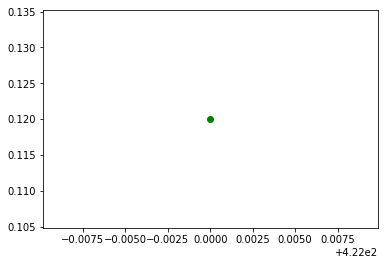

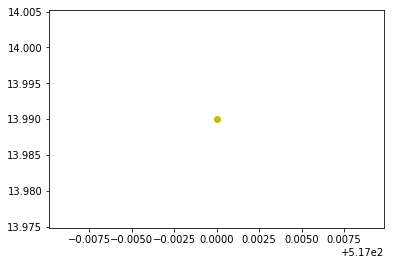

In [305]:
plot_result(res)